# Problem Set 4

In this exercise, you will use a feature-engineered dataset to determine whether a predictive model can be built to predict the complaint (of the Complaint Type that you decided to focus on in Week 2) by using past data.

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

### This notebook is similar to my Problem 3 notebook with some machine learning at the bottom

In [1]:
## Import important packages and set up notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.style.use('ggplot')
import matplotlib.cm as cm
import seaborn as sns

import pandas as pd
import pandas_profiling
import numpy as np
from numpy import percentile
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split

import os, sys
import calendar
import matplotlib.pyplot as plt


## Some default plot settings
plt.rc('font', size=18)        
plt.rc('axes', titlesize=22)      
plt.rc('axes', labelsize=18)      
plt.rc('xtick', labelsize=12)     
plt.rc('ytick', labelsize=12)     
plt.rc('legend', fontsize=12)   

local = True
if (local):
    BASE_PATH = "../"

import warnings
warnings.filterwarnings('ignore')


random = 47

In [2]:
df_311 = pd.read_csv(f"{BASE_PATH}nyc311.csv",index_col='unique_key')
df_PLUTO = pd.read_csv(f"{BASE_PATH}BX_18v1.csv")


In [3]:
df_PLUTO = df_PLUTO[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 
                     'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 
                     'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord','XCoord']]
df_PLUTO['ZipCode'].fillna(0,inplace=True)
df_PLUTO['ZipCode'] = df_PLUTO['ZipCode'].astype(int)

### Splice out the parts of the 311 data frame we want and drop columns without a zip

In [4]:
df = df_311[((df_311['complaint_type'] == 'HEAT/HOT WATER') | (df_311['complaint_type'] == 'HEATING'))]
df = df.dropna(subset=['incident_zip'])
df['incident_zip'] = df['incident_zip'].astype(int)

## We will drop rows we know are not the Bronx, clean up unkown rows, then drop anything which is not the Bronx

In [5]:
## Need to correct some of the 'Unspecified'
def borough_fix(city,zip_code):
    ### 1rst check if the borough is listed as the city
    bor_list = ['BRONX','BROOKLYN','MANHATTEN','QUEENS','STATEN ISLAND']
    brooklyn_zip = [11212, 11213, 11216, 11233, 11238,11209, 11214, 11228,
                  11204, 11218, 11219, 11230,
                  11234, 11236, 11239,
                  11223, 11224, 11229, 11235,
                  11201, 11205, 11215, 11217, 11231,
                  11203, 11210, 11225, 11226,
                  11207, 11208, 11211, 11222,
                  11220, 11232, 11206, 11221, 11237]
    queens_zip = [
        11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357, 11358, 11359, 11360,
        11365, 11366, 11367, 11412, 11423, 11432, 11433, 11434, 11435, 11436,
        11101, 11102, 11103, 11104, 11105, 11106, 11374, 11375, 11379, 11385,
        11691, 11692, 11693, 11694, 11695, 11697, 11004, 11005, 11411, 11413, 
        11422, 11426, 11427, 11428, 11429, 11414, 11415, 11416, 11417, 11418, 
        11419, 11420, 11421, 11368, 11369, 11370, 11372, 11373, 11377, 11378
    ]
    
    if city in bor_list:
        return city
    
    ### If not check the zipcode and match with borough
    # zipcodes from https://www.quora.com/What-is-the-ZIP-code-numbering-plan-for-New-York-City
    # https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm
    if zip_code in range(10000,10199):
        return 'MANHATTEN'
    if zip_code in range(10300,10400):
        return 'STATEN ISLAND'
    if zip_code in range(10400,10500):
        return 'BRONX'
    if zip_code in brooklyn_zip:
        return 'BROOKLYN'
    if zip_code in queens_zip:
        return 'QUEENS'
    else:
        return 'Unspecified'
## Drop Boroughs which are not Bronx    
df = df[((df['borough']=='BRONX') | (df['borough']== 'Unspecified'))]
df['borough'] = df.apply(lambda x: borough_fix(x['city'],x['incident_zip']) if (x['borough'] == 'Unspecified') 
                         else x['borough'] ,axis=1)
df = df[df['borough']=='BRONX']
df_311 = df[['incident_zip','incident_address','street_name','latitude','longitude']]

### We will now make sure to strip off any excess spaces from address columns in the two data frames and merge them.

In [6]:
def strip_and_clean(df,col):
    df[col] = df[col].str.strip()
    df[col] = (df[col].str.split()).str.join(' ')
    return df
        
df_311['incident_address'] = df_311['incident_address'].str.strip()
df_311['incident_address'] = (df_311['incident_address'].str.split()).str.join(' ')
df_311.rename(columns={'incident_address':'Address'},inplace=True)

df_PLUTO['Address'] = df_PLUTO['Address'].str.strip()
df_PLUTO['Address'] = (df_PLUTO['Address'].str.split()).str.join(' ')

df_PLUTO['Street'] = df_PLUTO['Address'].str.replace('^[^a-zA-Z]+', '')
df_PLUTO['Street'] = df_PLUTO['Street'].str.strip()
df_PLUTO['Street'] = df_PLUTO['Street'].str.replace('^[a-zA-Z]\s', '')
df_PLUTO['Street'] = (df_PLUTO['Street'].str.split()).str.join(' ')
df_PLUTO['Street'] = df_PLUTO['Street'].str.strip()

## Create a column in the PLUTO data frame indicating whether a Address had a report or now

In [7]:
def address_finder(address,incident_addresses):
    if (address in incident_addresses):
        return 1
    else:
        return 0


In [8]:
incident_addresses = df_311['Address'].unique()
df_PLUTO['complaint'] = df_PLUTO.apply(lambda x: address_finder(x['Address'],incident_addresses),axis=1)
#df_merged = pd.merge(df_311, df_PLUTO, on='Address', how='left')


# Clean the dataset 

# What each column uses as as unknown values
   - BldgArea: 0 means not available if NumBldgs != 0, else does not apply
      - We will replace with street mean if NumBldgs != 0 else 0
   - BldgDepth, BuiltFAR, : 
      - 0 will be replaced with street mean as long as num building != 0 else 0
   - FacilFAR:
      - 0 will be replaced with street mean   
   - Lot is tax lot so no blanks
   - LotArea: If the LOT AREA is zero, data is not available for the tax lot. 
      - Replace with street avg
   - LotDepth: 
      - Replace with street avg
   - NumBldgs: 0 is an acceptable value will not be replaced
   - NumFloors:
     - 0 will be replaced with street mean as long as num building != 0 else 0
   - OfficeArea: An OFFICE FLOOR AREA of zero can mean it is either not available or not applicable.
     - No replacement will be done
   - ResArea: A RESIDENTIAL FLOOR AREA of zero can mean it is either not available or not applicable
     - No replacement will be done
   - RetailArea: A RETAIL FLOOR AREA of zero can mean it is either not available or not applicable.
     - No replacement will be done
   - YearBuilt: 
     - Replace with street mode
   - YearAlter1:
     - Zero means no alteration so replace with YearBuilt
   - ZipCode
     - replace 0 with street mode
   
    
   
      
   
   
   

In [9]:
def missing_data(df):
    missing = [(c, df[c].isna().mean()*100) for c in df]
    missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
    missing = missing[missing.percentage > 0]
    display(missing.sort_values("percentage", ascending=False))
    
    
def fill_by_street_mean(df,col):
    mean_by_street = df.groupby('Street')[col].mean()
    df[col] = df.groupby('Street')[col].apply(lambda x: x.fillna(mean_by_street[x.name]))
    return df
  

### Since we are working off of address having no address will not work so we will drop all rows with NaN in address field

In [10]:
df_PLUTO = df_PLUTO.dropna(subset=['Address','Street'])

#### This part could be rewritten to be more efficient by using a single function which does all these replacements. Currently it is looping way more than needed [Done]

In [11]:
replace_list = ['BldgArea','BldgDepth','BuiltFAR','NumFloors']
replace_list_all = ['FacilFAR','LotArea','LotDepth']


means = df_PLUTO.groupby('Street').mean()
modes = df_PLUTO[['YearBuilt','ZipCode']].mode()

def replacer(x):
    street = x['Street']
    if(x['NumBldgs']!=0):
        for col in replace_list:
             if (x[col] == 0):
                x[col] = means.ix[street,col]
    else:
        for col in replace_list_all:
             if (x[col] == 0):
                x[col] = means.ix[street,col]  
                
    if (x['YearBuilt'] == 0):
        x['YearBuilt'] = modes['YearBuilt'][0]
        
    if (x['YearAlter1'] == 0):
        x['YearAlter1'] = x['YearBuilt']
        
    if (x['ZipCode'] == 0):
        x['ZipCode'] = modes['ZipCode'][0]
        
    return x 



In [12]:
df_PLUTO = fill_by_street_mean(df_PLUTO,'XCoord')
df_PLUTO = fill_by_street_mean(df_PLUTO,'YCoord')
df_PLUTO = df_PLUTO.dropna(subset=['YCoord','XCoord'])


df_PLUTO = df_PLUTO.apply(lambda x: replacer(x),axis = 1)


#df_PLUTO.head()


### We will not define some plotting functions to more easily analyse the corrilations

In [13]:
# Variable corrilation
def show_corrilations(df):
    corr = df.select_dtypes(include="number").corr()
    plt.subplots(figsize=(8,8));
    sns.heatmap(corr, cmap="RdBu", square=True, cbar_kws={"shrink": .7})
    plt.title("Correlation matrix of all numerical features\n")
    plt.tight_layout()
    plt.show()

# Variable corrilation with survived    
def corr_with_complaint(df):
    corr = df.select_dtypes(include="number").corr()
    plt.figure(figsize=(8,8));
    corr["complaint"].sort_values(ascending=True)[:-1].plot(kind="barh")
    plt.title("Correlation of numerical feature to Complaint at Address")
    plt.xlabel("Correlation to Complaint")
    plt.tight_layout()
    plt.show()

# Feature Engineering
   - Age of building
   - Age of Alteration
   - Binned tax lot: 
      - [1-999]:Traditional, 
      - [1001-6999]:Condominium Unit
      - [7501,7599]: Condominium Billing
      - [8000-8899]: Subterranean
      - [8900-8999]: DTM Dummy 
      - [9000-9899]: Air Rights
      - else : unknown

In [14]:
df_PLUTO['Age'] = 2019 - df_PLUTO['YearBuilt']
df_PLUTO['Age_of_Alt'] = 2019 - df_PLUTO['YearAlter1']

def taxer(x):
    tax_id = x['Lot']
    if (tax_id in range(1,1000)):
        return 'Traditional'
    
    elif (tax_id in range(1000,7000)):
        return 'Condo Unit'
    
    elif (tax_id in range(7501,7600)):
        return 'Condo Bill'
    
    elif (tax_id in range(8000,8900)):
        return 'Subterranean'
    
    elif (tax_id in range(8900,9000)):
        return 'DTM Dummy'
    
    elif (tax_id in range(9000,9900)):
        return 'Air Right'
    
    else:
        return 'Unknown'
        

df_PLUTO['Tax_type'] = df_PLUTO.apply(lambda x: taxer(x), axis = 1)

## We will now transform the catagorical
### Tax Type will be one_hot encoded and Street will be catboost encoded

In [15]:
def onehot_encode(df,columns):
    #df_numeric = df.select_dtypes(exclude=['object'])
    df_obj = df[columns].copy()

    cols = []
    for c in df_obj:
        dummies = pd.get_dummies(df_obj[c])
        dummies.columns = [c + "_" + str(x) for x in dummies.columns]
        cols.append(dummies)
    df_obj = pd.concat(cols, axis=1)

    df = pd.concat([df, df_obj], axis=1)
    df.reset_index(inplace=True, drop=True)
    return df  

def drop_catagotical(df):
    catagorical_cols = [col for col in df.columns if df[col].dtype == "object"]
    df = df.drop(catagorical_cols,axis=1)
    return df

def catboost_encode(df,columns):
    import category_encoders as ce
    #### Need to train test split with the same random seed we use outside
    #### Do not want to fit the data will test data, only traing data!
    X = df.drop(columns=['complaint'])
    y = df['complaint']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random)
    
    cb_enc = ce.CatBoostEncoder(cols=columns)
    count_encoded = cb_enc.fit(X_train[columns],y_train)
    df = df.join(cb_enc.transform(df[columns]).add_suffix('_cb'))
    return df

def binary_encode(df,columns):
    import category_encoders as ce
    
    bnry_enc = cd.BinaryEncoder(cols=columns)  
    df.join(bnry_enc.fit_transform(df[columns])).add_suffix('_cb')
    return df

In [45]:
#df_PLUTO_2 = binary_encode(df_PLUTO,'Street')

# We must split our data into training and testing sets
### Note we have done this inside the catboost as well to protect against data leaking

In [17]:
to_hot = ['Tax_type']
df_PLUTO = onehot_encode(df_PLUTO,to_hot)
df_PLUTO = catboost_encode(df_PLUTO,'Street')

df_PLUTO_final = drop_catagotical(df_PLUTO)

X = df_PLUTO_final.drop(columns=['complaint'])
y = df_PLUTO_final['complaint']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random)

# Hyperparameter Tuning

Models we will use are:
 - Ridge
 - Logistic
 - Random Forest
 - XGBoost 
 - XGBoost Dart
 - AdaBoost
 

In [20]:
from sklearn.linear_model import RidgeClassifier,Perceptron,SGDClassifier,LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier,BaggingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid , GridSearchCV
import xgboost as xgb

#import lightgbm as lgb

metric = 'accuracy'

### Ridge

In [21]:
ridge = RidgeClassifier()

ridge_pg = {'alpha':[1,10,100],'tol':[0.001,0.0001,0.00001]}

gs_ridge = GridSearchCV(ridge,param_grid = ridge_pg, scoring="accuracy", n_jobs= 4, verbose = 1)

gs_ridge.fit(X_train,y_train)

ridge_best = gs_ridge.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:    6.7s finished


### Random Forest

In [22]:
RFC = RandomForestClassifier()

rf_pg = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_pg, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 162 out of 162 | elapsed: 29.2min finished


### Linear Regression

In [23]:
lrc = LogisticRegression()

lrc_pg = {'penalty':['l1','l2','elasticnet'],'max_iter':[100,500,1000],'warm_start':[True],'tol':[0.001,0.0001,0.00001],'solver':['saga']
          ,'l1_ratio':[0.5]}

gs_lrc = GridSearchCV(lrc,param_grid = lrc_pg, scoring="accuracy", n_jobs= 4, verbose = 1)

gs_lrc.fit(X_train,y_train)

lrc_best = gs_lrc.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  81 out of  81 | elapsed:  8.1min finished


### XGBoost

In [27]:
XGBC =xgb.XGBClassifier(objective="reg:squarederror",random_state = random)


#Avg time to fit is 20 mins therefore to debug we dont fit
debug = False
if(debug):
    XGBC_pg = {'max_depth':[2]}
else:
    XGBC_pg = {'max_depth':[2,4],'learning_rate':[0.001,0.005],'n_estimators':[100,250,500],
                 'reg_alpha':[0.00001,0.0001],'colsample_bytree':[.5,.8]}
    
gsXGBC = GridSearchCV(XGBC,param_grid = XGBC_pg, scoring="accuracy", n_jobs= 4, verbose = 1)


gsXGBC.fit(X_train,y_train)

XGBC_best = gsXGBC.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 13.8min finished


### XGBoost Dart

In [28]:
XGBDC =xgb.XGBClassifier(objective="reg:squarederror",booster = 'dart',random_state = random)

#Avg time to fit is 18 mins
if(debug):
    XGBDC_pg = {'max_depth':[2]}
else:
    XGBDC_pg = {'max_depth':[2,4],'learning_rate':[0.001,0.005],'n_estimators':[100,250],
                 'reg_alpha':[0.00001,0.0001],'colsample_bytree':[.5,.8]}

gsXGBDC = GridSearchCV(XGBDC,param_grid = XGBDC_pg, scoring="accuracy", n_jobs= 4, verbose = 1)


gsXGBDC.fit(X_train,y_train)

XGBDC_best = gsXGBDC.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed: 14.4min finished


### Ada Boost

In [29]:
adac = AdaBoostClassifier()

if(debug):
    adac_pg = {'algorithm':['SAMME']}
else:
    adac_pg = {'algorithm':['SAMME'],'learning_rate':[.001,.01,.5],'n_estimators':[50,100,200]}
    
gsADAC =  GridSearchCV(adac,param_grid = adac_pg, scoring="accuracy", n_jobs= 4, verbose = 1)

gsADAC.fit(X_train,y_train)

ADAC_best = gsADAC.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:  1.3min finished


In [30]:
def important_features(names_classifiers):
    ncols = 2
    nrows = int(np.ceil(len(names_classifiers)/ncols))
    nclassifier = 0
    for row in range(nrows):
        for col in range(ncols):
            if(nclassifier == len(names_classifiers)):
                break
            name = names_classifiers[nclassifier][0]
            classifier = names_classifiers[nclassifier][1]
            indices = np.argsort(classifier.feature_importances_)[::-1][:10]
            ## LightGBM does not normalize importance so we renormalie, for normalized classifiers this does not make a difference
            g = sns.barplot(y=X.columns[indices][:10],x = (classifier.feature_importances_/(classifier.feature_importances_.sum()))[indices][:10] , orient='h',ax=axes[row][col])
            g.set_xlabel("Relative importance",fontsize=10)
            g.set_ylabel("Features",fontsize=10)
            g.tick_params(labelsize=8)
            g.set_title(name + " feature importance")
            nclassifier += 1

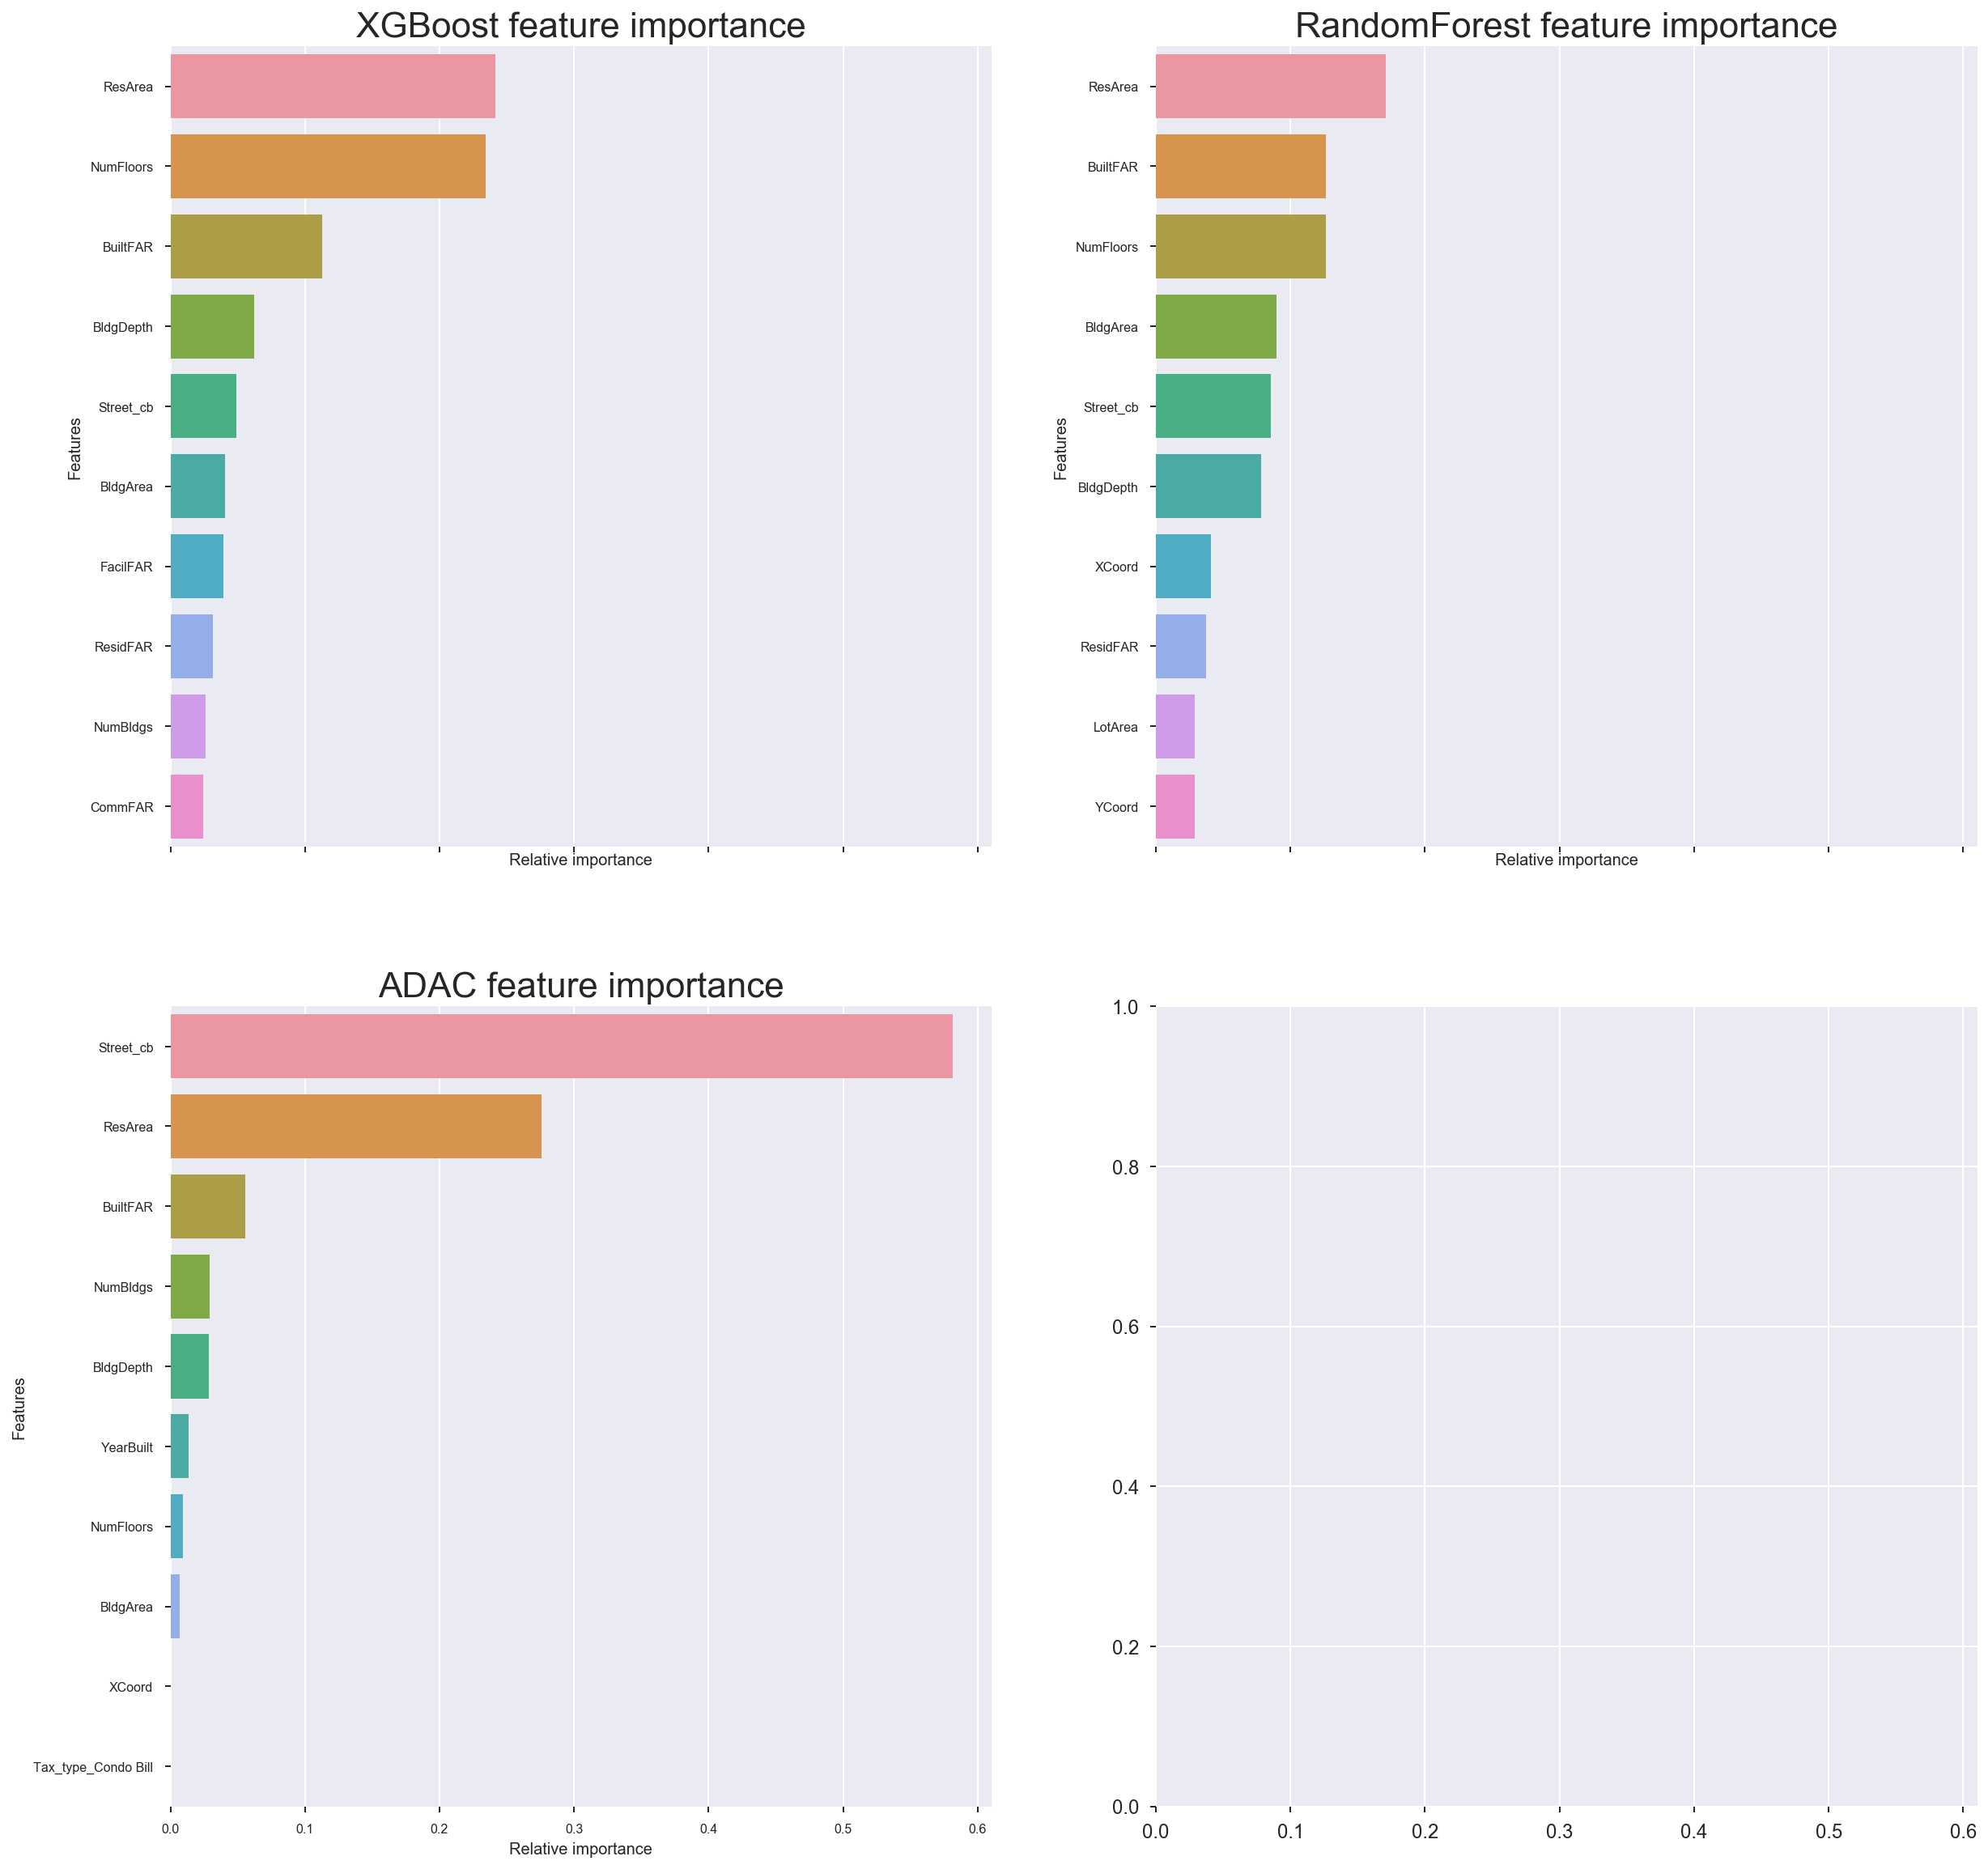

In [34]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(20,20))

names_classifiers = [("XGBoost",XGBC_best),("RandomForest",RFC_best),('ADAC',ADAC_best)]

important_features(names_classifiers)

# Ensemble

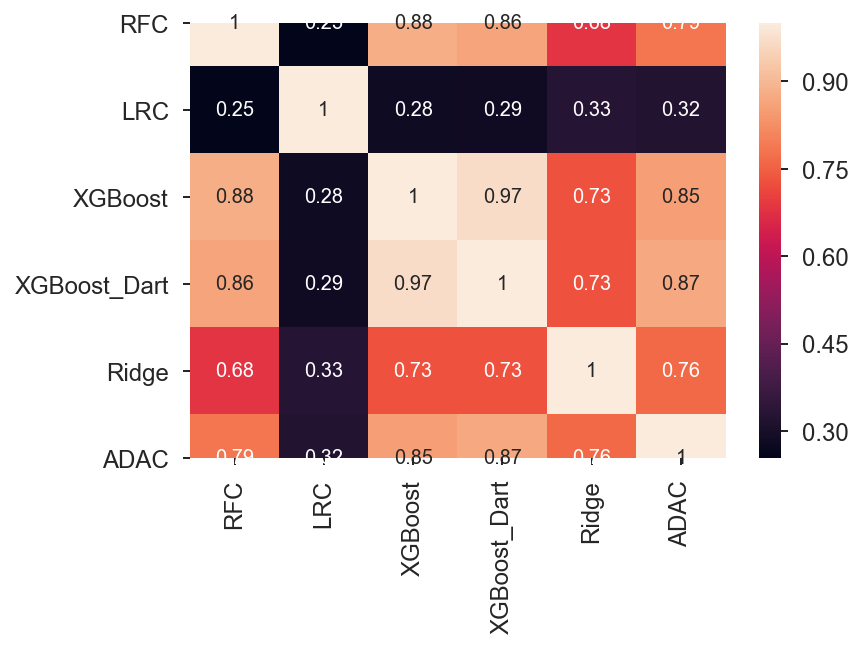

In [31]:
test_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_lrc = pd.Series(lrc_best.predict(X_test), name="LRC")
test_XGBC = pd.Series(XGBC_best.predict(X_test), name="XGBoost")
test_XGBDC = pd.Series(XGBDC_best.predict(X_test), name="XGBoost_Dart")
test_Ridge = pd.Series(ridge_best.predict(X_test), name="Ridge")
test_ADAC = pd.Series(ADAC_best.predict(X_test), name="ADAC")
# Concatenate all classifier results
ensemble_results = pd.concat([test_RFC,test_lrc,test_XGBC,test_XGBDC,test_Ridge,test_ADAC],axis=1)

# We also need training fits
train_RFC = pd.Series(RFC_best.predict(X_train), name="RFC")
train_lrc = pd.Series(lrc_best.predict(X_train), name="LRC")
train_XGBC = pd.Series(XGBC_best.predict(X_train), name="XGBoost")
train_XGBDC = pd.Series(XGBDC_best.predict(X_train), name="XGBoost_Dart")
train_Ridge = pd.Series(ridge_best.predict(X_train), name="Ridge")
train_ADAC = pd.Series(ADAC_best.predict(X_train), name="ADAC")
# Concatenate all classifier results
ensemble_results_train = pd.concat([train_RFC,train_lrc,train_XGBC,train_XGBDC,train_Ridge,train_ADAC],axis=1)



g= sns.heatmap(ensemble_results.corr(),annot=True)

### For ensembling it is good to have a spread in the models. Here we see that the models, except for the two XGBoost, are not too degenerate in their results.

In [32]:
adac_F = AdaBoostClassifier()

if(debug):
    adac_pg = {'algorithm':['SAMME']}
else:
    adac_pg = {'algorithm':['SAMME.R'],'learning_rate':[.001,.01,.5],'n_estimators':[25,100,150,200]}
    
gsADAC_F =  GridSearchCV(adac,param_grid = adac_pg, scoring="accuracy", n_jobs= 4, verbose = 1)

gsADAC_F.fit(ensemble_results_train,y_train)

ADAC_best_F = gsADAC_F.best_estimator_

test_Complaint = pd.Series(ADAC_best_F.predict(ensemble_results), name="test_complaint")



Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   36.5s finished


In [44]:
from sklearn.metrics import accuracy_score
for (model_name, model_results) in ensemble_results.iteritems():
    print('The accuracy of mode %s is: %.2f%s' %(model_name,accuracy_score(y_test,model_results)*100,'%' ))
print('The accuracy of the ensemble model is %.2f%s' %(accuracy_score(y_test,test_Complaint)*100,'%'))


The accuracy of mode RFC is: 84.84%
The accuracy of mode LRC is: 78.98%
The accuracy of mode XGBoost is: 84.53%
The accuracy of mode XGBoost_Dart is: 84.52%
The accuracy of mode Ridge is: 82.94%
The accuracy of mode ADAC is: 84.01%
The accuracy of the ensemble model is 84.84%


### As expected the accuracy of the ensemble is at least as good as the accuracy of the models being used to build it. For a better result one could use models which exhibit a larger distribution in theire results. One could also use a different ensemble model.  

## Question: Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

### Answer: Yes, however one must be careful to insure that that data being predicted from does not overlap with the addresses used to make the model. I trained six different models to use in an ensemble. My final model was an AdaBoost with inputs as the predicts of the six primary layer models. All models were trained on a training set of data and the final ensemble model was tested on the testing set which was cut from the full set before training. My accuracy is 84%

### During the feature engineering portion one must be careful not to leak data, in my case that meant making sure when I was CATBoosting the address categorical data that I only used data which was in the training set to transform both the training and testing set. If data in the testing set was also used one runs the risk of getting a model which has been trained on testing data.